In [1]:
#Importing the libraries
import nilearn
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib
from nilearn import plotting
import pylab

In [2]:
#Referencing the paths of the classifiers
path = "X:/IntMem/analyses/Pierre/localizer/MVPA/"
subj = np.array(range(30))
excluded = np.array([4,9,17,18,20])
subj = np.delete(subj,excluded)
Pair_clfs = ["" for x in subj] #Path of the scan classifiers
for i in range(subj.size):
    n = subj[i]+1
    sub =  "s" + str(n)
    Pair_clfs[i] = path + "PPA_250_clf_" + sub + ".pkl"

In [3]:
#Here, we are loading the univariate contrasts from the localizer => useful for feature selection
path = "X:/IntMem/analyses/Pierre/localizer/SPM"
subj = np.array(range(30))
#want to remove subjects [5,10,18,19,21]
excluded = np.array([4,9,17,18,20])
subj = np.delete(subj,excluded)
fs=["" for x in subj] #Path of each of the PPA contrast masks
for i in range(subj.size):
    n = subj[i]+1
    sub =  "/s" + str(n)
    fs[i] = path + sub + "/con1mask_PPA.nii"
PPA = [nib.load(i).get_data() for i in fs]
PPA_ac = [np.argwhere(i) for i in PPA] #storing all the activated voxels here
sizeAc = [PPA_ac[i].shape[0] for i in range(subj.size)]
mSz = PPA[0].shape
refOne = np.ones(subj.size)
refZero = np.zeros(subj.size)
AllPPA = np.empty([mSz[0],mSz[1],mSz[2],subj.size])
for i in range(subj.size):
    AllPPA[:,:,:,i] = PPA[i]
print(AllPPA.shape)
print(PPA_ac[3])

(79L, 95L, 79L, 25L)
[[21 31 30]
 [21 32 29]
 [21 32 30]
 ..., 
 [56 38 25]
 [56 38 26]
 [56 38 27]]


In [4]:
import os
#Localizer block orders loaded
path = "X:/IntMem/analyses/Pierre/localizer/"
os.chdir(path)
fname = "Block_Order.txt"
f = open(fname,"r")
cc = 0
order = [line.rstrip() for line in f] #rstrip removes the "\n" symbol
order2 = ["" for i in range(len(order)*2)]
for oo in order:
    order2[cc] = oo
    order2[cc+1] = oo
    cc = cc+2
F2,O2,S2 = np.zeros(len(order2)),np.zeros(len(order2)),np.zeros(len(order2))
for i in range(len(order2)):
    if(order2[i]=='F'):
        F2[i] = 1
    elif(order2[i]=='O'):
        O2[i] = 1
    else:
        S2[i] = 1
O_ind2 = np.argwhere(O2).flatten()
F_ind2 = np.argwhere(F2).flatten()
S_ind2 = np.argwhere(S2).flatten()
print(O_ind2)

[ 2  3  6  7 14 15 22 23 26 27 30 31 34 35 42 43 48 49 54 55]


In [5]:
#Loading the time onsets from the experimental data
onsets_path = "X:/IntMem/analyses/Pierre/localizer/SPM/Excel_Info/"
run1 = onsets_path + "R1_onsets.txt"
run2 = onsets_path + "R2_onsets.txt" 
f1 = open(run1,"r")
onsetsR1 = [line.rstrip().split("\t") for line in f1] #rstrip removes the "\n" symbol
onsetsR1 = [[int(a) for a in l] for l in onsetsR1]
f2 = open(run2,"r")
onsetsR2 = [line.rstrip().split("\t") for line in f2]
onsetsR2 = [[int(a) for a in l] for l in onsetsR2]
scanNb1 = len(onsetsR1[0])
scanNb2 = len(onsetsR2[0])
SjNb = np.shape(onsetsR1)[0]
scansR1 = np.zeros((SjNb,scanNb1))
scansR2 = np.zeros((SjNb,scanNb2))
print(np.shape(scansR1))
for i in range(SjNb):
    currL1 = onsetsR1[i]
    for j in range(len(currL1)):
        scansR1[i][j] = onsetsR1[i][j]/2000
    np.around(scansR1[i])
    currL2 = onsetsR2[i]
    for j in range(len(currL2)):
        scansR2[i][j] = onsetsR2[i][j]/2000
    np.around(scansR2[i])
scansR1 = [[(int(a)+3) for a in l] for l in scansR1] #Taking 3 scans after baseline
scansR2 = [[(int(a)+3) for a in l] for l in scansR2]

(25L, 64L)


In [6]:
#Important cell. Here we are dealing with the K-folds initialization for the MVPA cross-validation
K = 20
ResultsClf = np.zeros((subj.size,K))
NullRes = np.zeros((subj.size,K))
classification_accuracy = np.zeros(subj.size)
chance_level = np.zeros(subj.size)
path = "X:/IntMem/data"

In [7]:
#Getting the 3D coordinates for all voxels in a scan
AllInds = np.zeros((mSz[0]*mSz[1]*mSz[2],3))
ii = 0
for v1 in range(mSz[0]):
    for v2 in range(mSz[1]):
        for v3 in range(mSz[2]):
            AllInds[ii] = [v1,v2,v3]
            ii = ii+1
print(AllInds)
print(mSz[0]*mSz[1]*mSz[2])

[[  0.   0.   0.]
 [  0.   0.   1.]
 [  0.   0.   2.]
 ..., 
 [ 78.  94.  76.]
 [ 78.  94.  77.]
 [ 78.  94.  78.]]
592895


In [8]:
#Apply PPA mask here
NewInds = np.zeros((subj.size,mSz[0]*mSz[1]*mSz[2]))
for su in range(subj.size):
    NewInds_curr = np.zeros((mSz[0],mSz[1],mSz[2]))
    curr_ac = PPA_ac[su]
    for i in range(curr_ac.shape[0]):
        curIdx = curr_ac[i]
        v1, v2, v3 = curIdx[0], curIdx[1], curIdx[2]
        NewInds_curr[v1,v2,v3] = 1
    NewInds_curr = NewInds_curr.flatten()
    NewInds[su] = np.array([int(x) for x in NewInds_curr])
print(NewInds_curr)
print(NewInds_curr.shape[0])
print(np.sum(NewInds_curr))
print(NewInds.shape)

[ 0.  0.  0. ...,  0.  0.  0.]
592895
1391.0
(25L, 592895L)


In [9]:
#Initialization of the parameters
from os import listdir
from os.path import isfile, join
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import KFold, cross_val_score
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn import svm
from sklearn.externals import joblib
import sklearn

#we want the 250 most informative voxels
NbVoxels = 250
select250best = SelectKBest(score_func=f_classif, k=NbVoxels)
path = "X:/IntMem/data"

PredictCLF_R1 = np.zeros((SjNb,scanNb1))
PredictCLF_R2 = np.zeros((SjNb,scanNb2))
Predict_ProbaCLF_R1 = np.zeros((SjNb,scanNb1,2))
Predict_ProbaCLF_R2 = np.zeros((SjNb,scanNb2,2))

In [10]:
Torun = range(subj.shape[0])
print(Torun)
print(subj[3])

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
3


In [10]:
#Big loop to compute the scene reinstatement classifier probabilities
Torun = range(subj.shape[0])
for su in Torun:
    #Load the data from the localizer
    n = subj[su]+1
    print("Currently dealing with subject %s" % n)
    sub =  "/s" + str(n)
    path_sub1 = path + sub + "/func/localizer/run1/"
    path_sub2 = path + sub + "/func/localizer/run2/"
    files1 = [f for f in listdir(path_sub1) if (isfile(join(path_sub1, f)) and f.startswith('swr'))]
    files2 = [f for f in listdir(path_sub2) if (isfile(join(path_sub2, f))and f.startswith('swr'))]
    fileR1 = path_sub1 + files1[0]
    #Load the scans
    LocScansR1 = nib.load(fileR1).get_data()
    fileR2 = path_sub2 + files2[0]
    LocScansR2 = nib.load(fileR2).get_data()
    LocScans = np.concatenate((LocScansR1,LocScansR2),axis=3)
    NbScans = LocScans.shape[3]
    #Storing the data in X. Importantly, we first remove the non-zero voxels and we want to de-mean (and use standard deviations)
    X = np.zeros((NbScans,NbVoxels))
    mod4ind = [i for i in range(NbScans) if ((np.mod(i,10)==3) or (np.mod(i,10)==6))]
    y_fit = np.transpose(S2)
    y_fit = np.delete(y_fit,O_ind2)
    Xsub = np.zeros((NbScans,LocScans.shape[0]*LocScans.shape[1]*LocScans.shape[2]))
    #Flatten patterns of activity to make sure we are dealing with vectors
    for t in range(Xsub.shape[0]):
        Xsub[t,:] = LocScans[:,:,:,t].flatten()
    Xsub = Xsub[mod4ind,:]
    Xsub = np.delete(Xsub,O_ind2,0)
    nonzeros = np.sum(Xsub, axis=0) !=0
    nz = np.argwhere(nonzeros).flatten()
    X_nz = Xsub[:,nz]
    #Demean data whole-brain and then select the 250 voxels of interest.
    Xsub = (X_nz - np.mean(X_nz, axis=0,keepdims=True))/np.std(X_nz, axis=0, keepdims=True)
    NewInds_curr = NewInds[su]
    maskIndx = NewInds_curr[nz]
    Idx = np.argwhere(maskIndx).flatten()
    X_nz = Xsub[:,Idx]
    Inds_nz = AllInds[Idx]
    #Then, we perform feature selection again to get the 250 most informative voxels
    select250best.fit(X_nz,y_fit)
    path_sub1 = path + sub + "/func/experiment/run1/"
    path_sub2 = path + sub + "/func/experiment/run2/"
    Pair_clf = joblib.load(Pair_clfs[su]) #Loading the classifier (make sure this was saved as a file first)
    files1 = [f for f in listdir(path_sub1) if (isfile(join(path_sub1, f)) and f.startswith('zswr'))]
    files2 = [f for f in listdir(path_sub2) if (isfile(join(path_sub2, f))and f.startswith('zswr'))]
    fileR1 = path_sub1 + files1[0] 
    ExpScansR1 = nib.load(fileR1).get_data()
    fileR2 = path_sub2 + files2[0]
    ExpScansR2 = nib.load(fileR2).get_data()
    ShapeExpScan1 = np.shape(ExpScansR1)
    ShapeExpScan2 = np.shape(ExpScansR2)
    #Dealing with run 1
    curscans = scansR1[su]
    X1 = np.zeros((ShapeExpScan1[3],ShapeExpScan1[0]*ShapeExpScan1[1]*ShapeExpScan1[2]))
    Xdata1 = np.zeros((scanNb1,NbVoxels))
    for t in range(ShapeExpScan1[3]):
        X1[t,:] = ExpScansR1[:,:,:,t].flatten()
    X1 = X1[curscans,:]
    X1 = X1[:,nz]
    X1 = (X1 - np.mean(X1, axis=0,keepdims=True))/np.std(X1, axis=0, keepdims=True)
    X1 = X1[:,Idx]
    Xdata1 = select250best.transform(X1)
    PredictCLF_R1[su] = Pair_clf.predict(Xdata1)
    Predict_ProbaCLF_R1[su] = Pair_clf.predict_proba(Xdata1)
    #Dealing with run 2
    curscans = scansR2[su]
    X2 = np.zeros((ShapeExpScan2[3],ShapeExpScan2[0]*ShapeExpScan2[1]*ShapeExpScan2[2]))
    Xdata2 = np.zeros((scanNb2,NbVoxels))
    for t in range(ShapeExpScan2[3]):
        X2[t,:] = ExpScansR2[:,:,:,t].flatten()
    X2 = X2[curscans,:]
    X2 = X2[:,nz]
    X2 = (X2 - np.mean(X2, axis=0,keepdims=True))/np.std(X2, axis=0, keepdims=True)
    X2 = X2[:,Idx]
    Xdata2 = select250best.transform(X2)
    PredictCLF_R2[su] = Pair_clf.predict(Xdata2)
    Predict_ProbaCLF_R2[su] = Pair_clf.predict_proba(Xdata2)

Currently dealing with subject 1


C:\Program Files\Anaconda2\lib\site-packages\ipykernel\__main__.py:56: RuntimeWarning: invalid value encountered in divide
C:\Program Files\Anaconda2\lib\site-packages\ipykernel\__main__.py:69: RuntimeWarning: invalid value encountered in divide


Currently dealing with subject 2
Currently dealing with subject 3
Currently dealing with subject 4
Currently dealing with subject 6
Currently dealing with subject 7
Currently dealing with subject 8
Currently dealing with subject 9
Currently dealing with subject 11
Currently dealing with subject 12
Currently dealing with subject 13
Currently dealing with subject 14
Currently dealing with subject 15
Currently dealing with subject 16
Currently dealing with subject 17
Currently dealing with subject 20
Currently dealing with subject 22
Currently dealing with subject 23
Currently dealing with subject 24
Currently dealing with subject 25
Currently dealing with subject 26
Currently dealing with subject 27
Currently dealing with subject 28
Currently dealing with subject 29
Currently dealing with subject 30


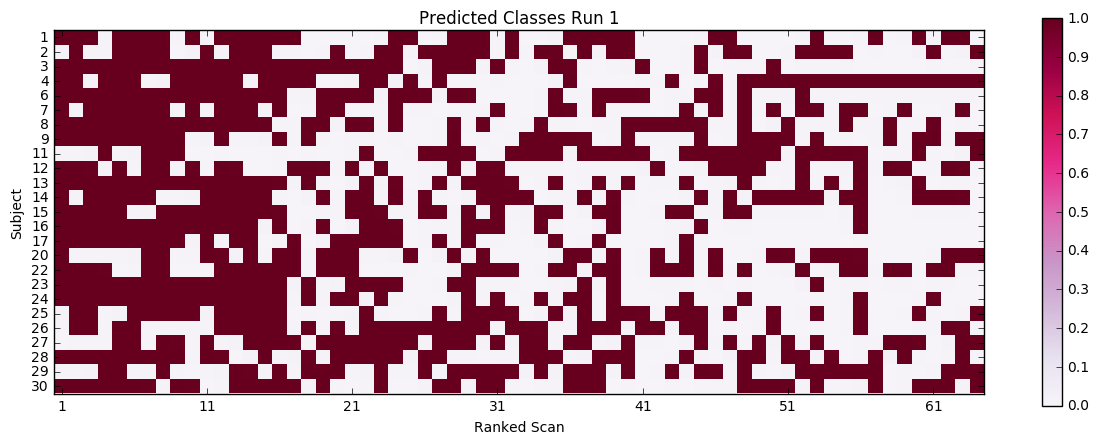

In [11]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15,5))
my_xticks = [1,11,21,31,41,51,61]
ss = [s+1 for s in subj]
my_yticks = ss
plt.imshow(PredictCLF_R1, cmap = 'PuRd', interpolation='none', vmin=0.0, vmax=1.0)
plt.ylabel('Subject')
plt.xlabel('Ranked Scan')
plt.xticks([0,10,20,30,40,50,60], my_xticks)
plt.yticks(range(25),my_yticks)
plt.title('Predicted Classes Run 1')
plt.colorbar()
plt.show()

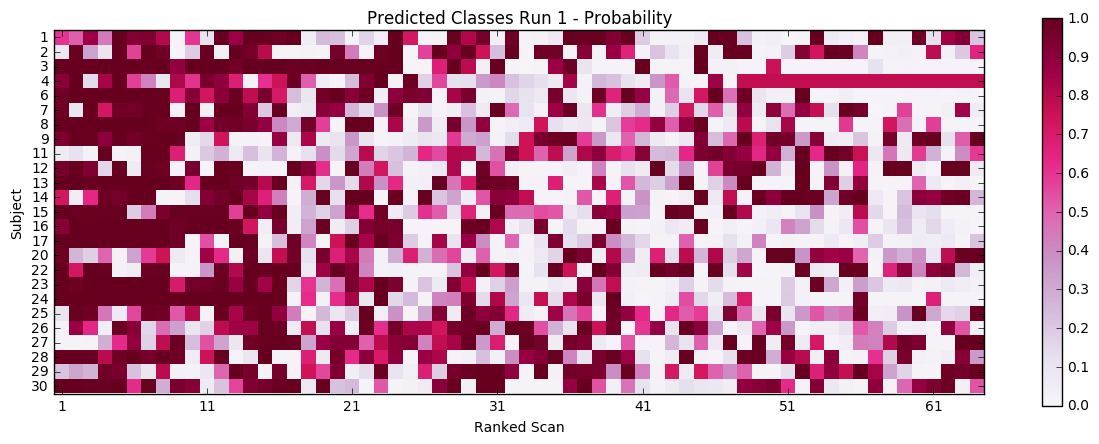

In [12]:
Probas1 = np.zeros((SjNb,scanNb1))
for su in range(SjNb):
    for ii in range(scanNb1):
        Probas1[su][ii] = Predict_ProbaCLF_R1[su][ii][1]
plt.figure(figsize=(15,5))
my_xticks = [1,11,21,31,41,51,61]
my_yticks = ss
plt.imshow(Probas1, cmap = 'PuRd', interpolation='none', vmin=0.0, vmax=1.0)
plt.ylabel('Subject')
plt.xlabel('Ranked Scan')
plt.xticks([0,10,20,30,40,50,60], my_xticks)
plt.yticks(range(25),my_yticks)
plt.title('Predicted Classes Run 1 - Probability')
plt.colorbar()
plt.show()

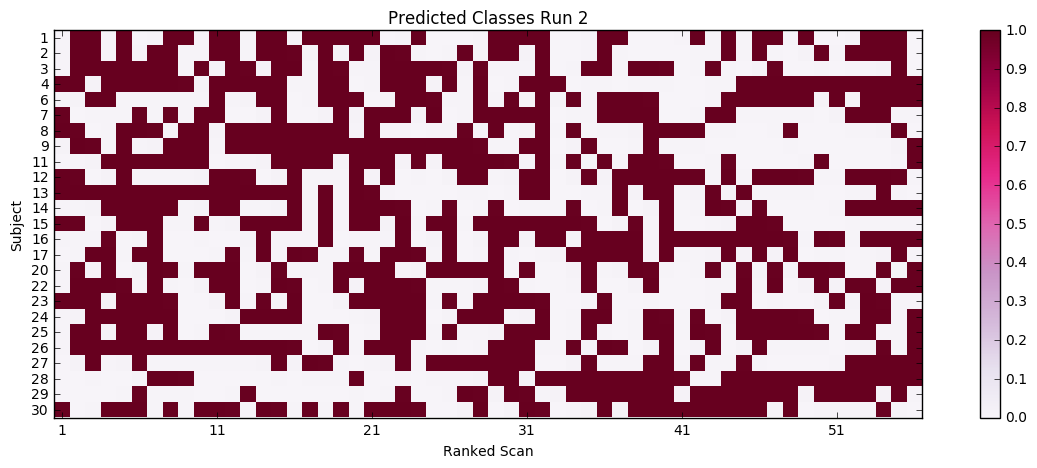

In [13]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15,5))
my_xticks = [1,11,21,31,41,51]
ss = [s+1 for s in subj]
my_yticks = ss
plt.imshow(PredictCLF_R2, cmap = 'PuRd', interpolation='none', vmin=0.0, vmax=1.0)
plt.ylabel('Subject')
plt.xlabel('Ranked Scan')
plt.xticks([0,10,20,30,40,50], my_xticks)
plt.yticks(range(25),my_yticks)
plt.title('Predicted Classes Run 2')
plt.colorbar()
plt.show()

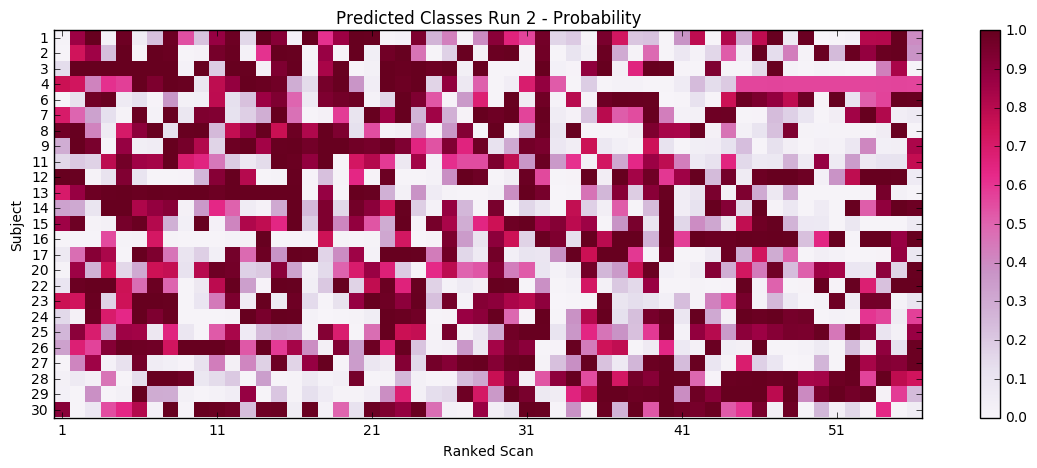

In [14]:
Probas2 = np.zeros((SjNb,scanNb2))
for su in range(SjNb):
    for ii in range(scanNb2):
        Probas2[su][ii] = Predict_ProbaCLF_R2[su][ii][1]
plt.figure(figsize=(15,5))
my_xticks = [1,11,21,31,41,51]
my_yticks = ss
plt.imshow(Probas2, cmap = 'PuRd', interpolation='none', vmin=0.0, vmax=1.0)
plt.ylabel('Subject')
plt.xlabel('Ranked Scan')
plt.xticks([0,10,20,30,40,50], my_xticks)
plt.yticks(range(25),my_yticks)
plt.title('Predicted Classes Run 2 - Probability')
plt.colorbar()
plt.show()